In [ ]:
#! -*- coding: utf-8 -*-

## 4. PyCBCチュートリアル：シグナルのコンシステンシと意義

重力波データの研究、コンパクトバイナリ合併による天体物理源の発見、それらのパラメータの研究に使用される[PyCBC](http://github.com/ligo-cbc/pycbc) ライブラリを使用します。 これらは、LIGOとVirgoの協力がLIGO / Virgoデータの重力波を見つけるために使用するのと同じツールのいくつかです

このチュートリアルでは、簡略化された検索（途中で指摘されているようないくつかの仮定があります）を仮定して、信号のピークの有意度を見積もります。 また、標準の信号一コンシステンシテストの1つを使用して、バックグラウンドからの非ガウス・トランジェント・ノイズを除去するのに役立てます。

他の[例](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) とモジュールレベルのドキュメンテーションは[ここ](http://pycbc.org/pycbc/latest/html/py-modindex.html)にあります

### GW170814のVirgo SNRピークの意義

我々は、LIGO-HanfordとLIGO-Livingston観測所で観測された大きなピークに近い、Virgoで観測された信号対雑音ピークの有意性を推定する。

この目的のために、実際にGW170814のマッチトフィルタリングに基づく分析の場合のように、LIGO検出器単独の信号に基づいてVirgoのデータから重力波信号の存在が確認されたと考える。

私たちが求める質問は、次のように表現できます。 * 3つの観測所の間の一定の光速移動時間内に、ノイズがVirgoデータで観測された最大ピークよりも大きいか大きいかの確率はどれくらいですか？*これは帰無仮説検定の一形態です。 [p値](https://en.wikipedia.org/wiki/P-value)。

このノートブックの目的のために、我々はいくつかの単純化仮定を追加するかもしれない。

#### 重力歪みデータの読み込みと前処理　####

このセクションでは、GW170814の周りの短いデータを読み、前のチュートリアルでも説明した基本的な前処理を実行します。 また、データのパワースペクトルも計算します。

特に、我々は、データのパワースペクトル推定値がこの短い時間にわたって一定であり、事象時間に推定値（非常に大まかに）を一致させることを選択したという事実によって偏っていないことを前提としている。 データが実際には静止している、ガウスである、とは仮定しません。
または非天体物理的な事象が入っていないと仮定します。

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


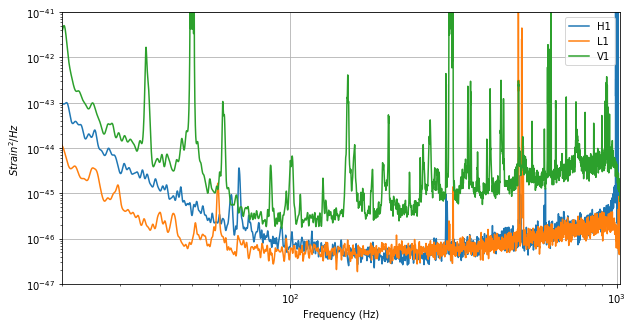

In [1]:
%matplotlib inline

import pylab
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

m = Merger("GW170814")

ifos = ['H1', 'L1', 'V1']
data = {}
psd = {}

pylab.figure(figsize=[10, 5])

for ifo in ifos:
    # Read in and precondition the data
    ts = m.strain(ifo).highpass_fir(15, 512)
    data[ifo] = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

    # Estimate the power spectral density of the data
    # This chooses to use 2s samples in the PSD estimate.
    # One should note that the tradeoff in segment length is that
    # resolving narrow lines becomes more difficult.
    p = data[ifo].psd(2)
    p = interpolate(p, data[ifo].delta_f)
    p = inverse_spectrum_truncation(p, 2 * data[ifo].sample_rate, low_frequency_cutoff=15.0)
    psd[ifo] = p
    
    pylab.plot(psd[ifo].sample_frequencies, psd[ifo], label=ifo)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-47, 1e-41)
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

#### テンプレート波形を生成し、Signal-to-noiseタイムシリーズを計算する ####

信号対雑音時系列を計算するには、信号の推定値を生成する必要があります。 この目的のために、ソースブラックホールは回転しておらず、等質量であり、システム全体の総質量推定値と一致すると仮定する。 より良い方法は、LIGOデータのみの分析からの最尤推定を使用することですが、このチュートリアルでは十分です。

In [2]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

# Calculate the component mass of each black hole in the detector frame
cmass = m.median1d("mtotal") / 2      # This is in the source frame
cmass *= (1 + m.median1d("redshift")) # apply redshift to get to the detector frame

# This is a frequency domain waveform generator. It has a very similar syntax to the time domain
# waveform function used in prior tutorials. This function returns both a plus and a cross
# polarization waveform, but we will just use the plus polarization in building our template
# as these are only different by a phase offset in this specific case.
hp, _ = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=cmass, mass2=cmass,
                         f_lower=20.0, delta_f=data[ifo].delta_f)
hp.resize(len(psd[ifo]))

# For each observatory use this template to calculate the SNR time series
snr = {}
for ifo in ifos:
    snr[ifo] = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=20)
    snr[ifo] = snr[ifo].crop(5, 4)

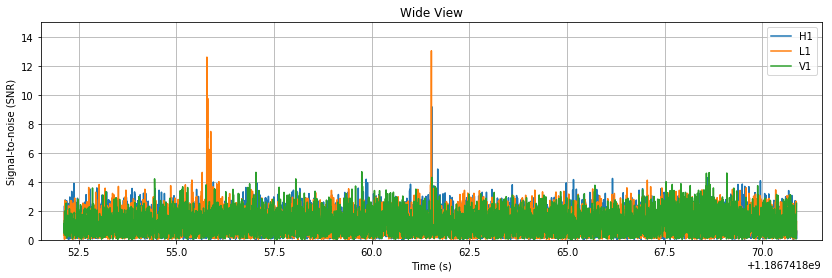

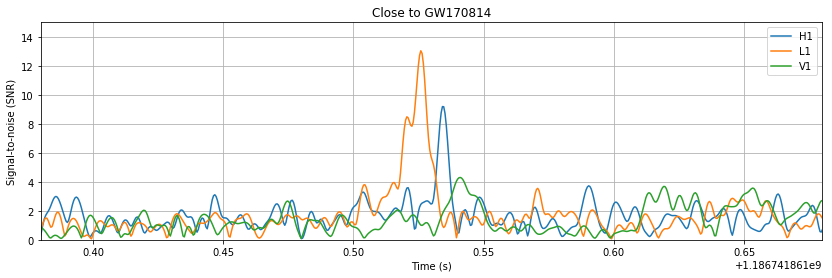

In [3]:
# Show a couple sizes
for w, title in [(10, 'Wide View'), (.15, 'Close to GW170814')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()

上記のSNRの時系列図には、各検出器のGW170814の周りに素晴らしいピークがありますが、他の時間にも大きなピークがあることがわかります。 LIGO / Virgoデータは、分析がLIGOデータを高感度で検索するために解析で処理しなければならない一時的な（すなわち期間が限定された）ノイズアーチファクトを含む。 これに対処するための1つのアプローチについては、このチュートリアルの後半で概説します。

#### データが実際に私たちのモデルにどの程度適合していますか？ ####

実際にデータが$\chi^2$ベースの信号一貫性テストを使用するためにモデルにどの程度適合しているかをテストする方法の1つです。 私たちは[この論文](https://arxiv.org/pdf/gr-qc/0405045.pdf)に記述されたバージョンのテストを採用しています。 模式的に、テンプレートを$p$個のビンに分割し、それぞれがSNR（$\rho_i$）にどのくらい貢献するかを確認します。 1つのビン内のSNRと総SNR（$\rho$）の期待される割合との差として統計を計算することができます。

$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / p)^2
$

これは$2p-2$の自由度を持ちます。各SNRは、信号が寄与する可能性のある直交位相の両方を表す複素数だからです。 また、各ビンの合計は、総SNRを定義しなければならないという事実に起因する制約も存在する。 このノートブックでは、この統計量を自由度の数で割って正規化し、$\chi^2_r$を生成します。

テンプレートがデータとよく一致しない場合にはこの統計値は高くなり、データがガウスノイズである場合、またはガウスノイズに加えて期待される信号が含まれている場合にはほぼ1になると予測します。

In [4]:
from pycbc.vetoes import power_chisq
chisq = {}
for ifo in ifos:
    # The number of bins to use. In principle, this choice is arbitrary. In practice,
    # this is empirically tuned.
    nbins = 26
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, psd[ifo], low_frequency_cutoff=20.0)
    chisq[ifo] = chisq[ifo].crop(5, 4)
    
    dof = nbins * 2 - 2
    chisq[ifo] /= dof

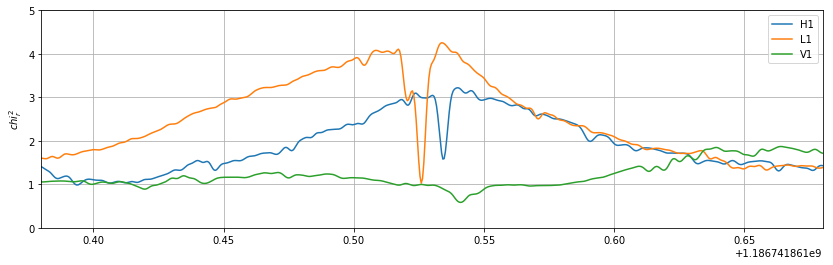

In [5]:
pylab.figure(figsize=[14, 4])

for ifo in ifos:
    pylab.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo)
    
pylab.legend()
pylab.grid()
pylab.xlim(m.time -0.15, m.time + 0.15)
pylab.ylim(0, 5)
pylab.ylabel('$chi^2_r$')
pylab.show()

$\chi^2_r$時系列には注目すべき機能がいくつかあります。 各観測所のSNRのピーク時の値にはディップがあることがわかります。 これは、テンプレートのデータがデータの信号と揃うようになるためです。 また、値はこの最小値のまわりをちょうど上昇する。 これは、テンプレートがデータ内の真の信号に対してスライドし始めているが、完全にはそろっていないためです。

#### 信号に適合しないダウンタイムを助けるためにSNRを再重み付けする####

我々が取ることができる1つのアプローチは、データがガウス雑音またはガウス雑音+我々のテンプレートとして現れない時間の重みを減ずることである。 これは、SNR時系列と$\chi^2_r$時系列を以下のように組み合わせて行うことができます。 これは、最初のLIGOからSNRを再加重するために使用され、最初の2つのAdvanced LIGO観測で使用されています。 このチュートリアルでは、この統計によってイベントをランク付けすることを選択します。

$\hat{\rho} = \frac{\rho}{ [1 + (\chi^2_r)^3]^{1/6}}$ where $\chi^2 > 1$, otherwise $\rho$

アドバンストLIGOでの一致（すなわち、複数の検出器での発生）イベントのランク付けの方法については、[ここ](http://iopscience.iop.org/article/10.3847/1538-4357/aa8f50/pdf)にあります。

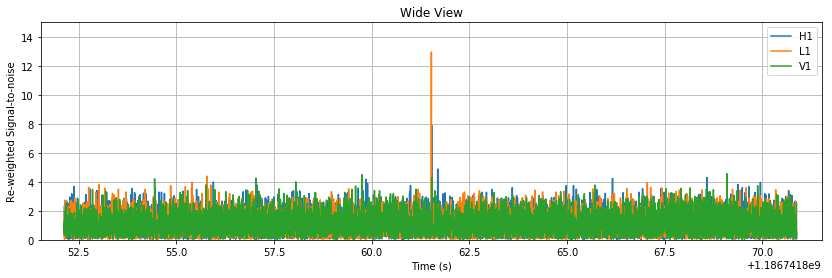

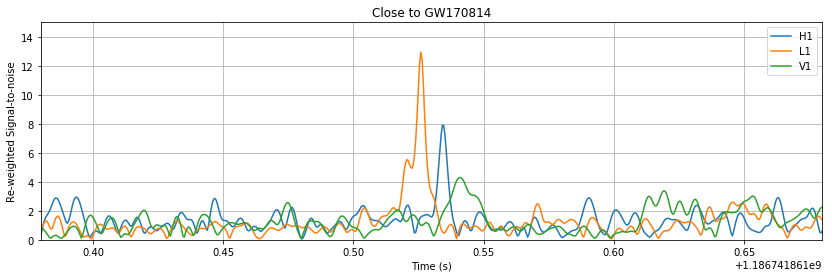

In [6]:
from pycbc.events import newsnr

# The rho-hat term above is named "newsnr" here
nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}

# Show a couple sizes
for w, title in [(10, 'Wide View'), (.15, 'Close to GW170814')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()

すべての検出器でGW170814のピークはほぼ同じ信号強度であるが、それは時系列でピークであった他の時間ではもはや大きなピークが存在しないことがわかる。

#### 背景と重要性の計算 ####

このセクションでは、virgo re-weighted SNR時系列のピークがどれだけ重要であるかを決定します。

最初に、LIGOで観測されたピークと比較してピークが予想される場所を決定することで、これを行います。これは、天体物理的な起源が、それらの間の光の移動時間より長くない観測所間の遅延を引き起こすだけであるという制約によって設定される。 [`pycbc.detector.Detector`](http://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.detector.Detector)クラスは、これらの種類の質問をする便利なメソッドを提供します。

次に、LIGOで観測されたピークの周りのこのウィンドウのSNRのピークを計算します。これが私たちの「オンソース」です。

最後に、オンソースの重要性を判断するために、大規模または大規模のピークがバックグラウンドに現れる可能性を比較します。我々の背景は、「オフソース」からのSNR時系列の一部、すなわちオンソースと重複しない時間を取ることによって経験的に測定される。バイアスされた有意推定値を避けるための重要な基準は、バックグラウンドと実験が同じように実行されることである。

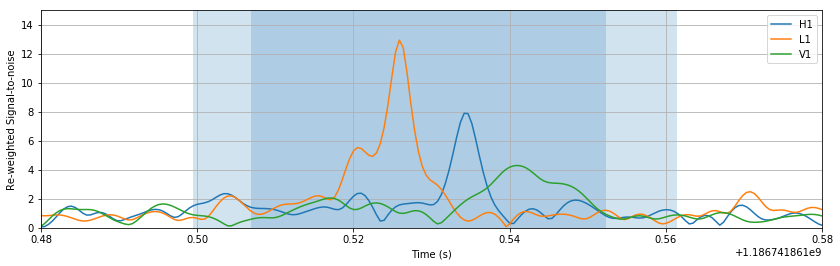

Virgo Peak has a statistic value of 4.30008545423


In [7]:
import numpy
from pycbc.detector import Detector

# Calculate the time of flight between the Virgo detectors and each LIGO observatory
d = Detector("V1")
tof = {}
tof['H1'] = d.light_travel_time_to_detector(Detector("H1"))
tof['L1'] = d.light_travel_time_to_detector(Detector("L1"))

# Record the time of the peak in the LIGO observatories
ptime = {}

pylab.figure(figsize=[14, 4])
for ifo in ifos:
    
    # shade the region around each LIGO peak that could have a peak in Virgo if from
    # an astrophysical source
    if ifo is not 'V1':
        ptime[ifo] = snr[ifo].sample_times[nsnr[ifo].argmax()]
        pylab.axvspan(ptime[ifo] - tof[ifo], ptime[ifo] + tof[ifo], alpha=0.2, lw=10)
        
    pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

# Calculate the span of time that a Virgo peak could in principle happen in from time of flight
# considerations.
start = ptime['H1'] - tof['H1']
end = ptime['L1'] + tof['L1']

# convert the times to indices along with how large the region is in number of samples
window_size = int((end - start) * snr['V1'].sample_rate)
sidx = int((start - snr['V1'].start_time) * snr['V1'].sample_rate)
eidx = sidx + window_size

# Calculate the "on-source" peak re-weighted (newsnr) statistic value.
onsource = nsnr['V1'][sidx:eidx].max()

pylab.legend()
pylab.grid()
pylab.xlim(m.time - .05, m.time + .05)
pylab.ylim(0, 15)
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

print('Virgo Peak has a statistic value of {}'.format(onsource))

上記のプロットでは、再加重されたSNRの時系列が表示されます。 さらに、LIGO観測所のピークに基づいてVirgo信号と一致する領域を陰影付けしました。 より暗い領域でのみ、両方のLIGO観測所と一致するSNRにピークを持つことが可能です。

In [8]:
# Now that we've calculate the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks = []
i = 0
while i + window_size < len(nsnr['V1']):
    p = nsnr['V1'][i:i+window_size].max()
    peaks.append(p)
    i += window_size
    
    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2
    
peaks = numpy.array(peaks)

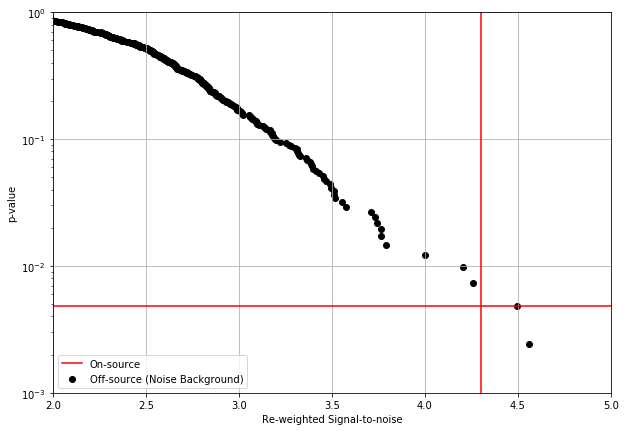

The p-value associated with the GW170814 peak is 0.00487804878049


In [9]:
# The p-value is just the number of samples observed in the background with a 
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = numpy.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource).sum() / float(len(peaks))

pylab.figure(figsize=[10, 7])
pylab.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

pylab.axvline(onsource, label='On-source', color='red')
pylab.axhline(pvalue, color='red')

pylab.legend()
pylab.yscale('log')
pylab.grid()
pylab.ylim(1e-3, 1e0)
pylab.ylabel('p-value')
pylab.xlabel('Re-weighted Signal-to-noise')

pylab.xlim(2, 5)
pylab.show()

print("The p-value associated with the GW170814 peak is {}".format(pvalue))

このチュートリアルでは、耳障りな人が騒音のせいで約0.5％の確率で出現するほど大きなVirgoのピークを見つける。 これは比較的低い確率であるため、観測されたピークが雑音だけに起因するという帰無仮説を拒否することがあります。 このチュートリアルを単純化すると、0.3％のp値を報告した[GW170814発見の論文](https://arxiv.org/pdf/1709.09660.pdf)と一致する結果が得られました。